<a href="https://colab.research.google.com/github/ryosato12/co-act/blob/main/coactivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install ONE-api
! pip install ibllib
! pip install statsmodels

In [ ]:
from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

Connected to https://openalyx.internationalbrainlab.org as user "intbrainlab"
Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/tmpp1shn9gd/cache.zip Bytes: 4118421


100%|██████████| 3.9276323318481445/3.9276323318481445 [00:00<00:00,  6.52it/s]


In [ ]:
from brainbox.io.one import SpikeSortingLoader, SessionLoader
from ibllib.atlas import AllenAtlas
import numpy as np

ba = AllenAtlas()
one = ONE()

acronym = 'VPL'
insertions = one.search_insertions(atlas_acronym=acronym, query_type='remote')
print(f'No. of insertions in {acronym}: {len(insertions)}')

/usr/local/lib/python3.10/dist-packages/ibllib/atlas/atlas.py:13: DeprecationWarning: ibllib.atlas.atlas.AllenAtlas is deprecated. Use iblatlas.atlas.AllenAtlas instead
  warnings.warn(warning_text, DeprecationWarning)


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/average_template_25.nrrd Bytes: 32998960


100%|██████████| 31.470260620117188/31.470260620117188 [00:17<00:00,  1.75it/s]


Downloading: /root/Downloads/ONE/openalyx.internationalbrainlab.org/histology/ATLAS/Needles/Allen/annotation_25.nrrd Bytes: 4035363


100%|██████████| 3.848422050476074/3.848422050476074 [00:08<00:00,  2.33s/it]


No. of insertions in VPL: 22


In [ ]:
all_clusters = []
for pid in insertions:
  eid, name = one.pid2eid(pid)
  # Load in clusters data that we need, amps and channels attributes
  clusters = one.load_object(eid, 'clusters', attribute=['amps', 'channels'], collection=f'alf/{name}/pykilosort')
  # Load in channels data that we need. This gives the Allen CCF location of each channel
  channels_atlas_id = one.load_dataset(eid, 'channels.brainLocationIds_ccf_2017', collection=f'alf/{name}/pykilosort')
  # Use channels_atlas_id and clusters.channels to compute the atlas_id of each cluster
  clusters['atlas_ids'] = channels_atlas_id[clusters['channels']]
  # Use regions object to convert atlas ids to acronyms
  clusters['acronyms'] = ba.regions.id2acronym(clusters['atlas_ids'])
  # Convert clusters object to pandas dataframe and add the pid as a column
  clusters_df = clusters.to_df()
  clusters_df['pid'] = pid
  clusters_df['eid'] = eid
  # Append table from individual pid to list
  all_clusters.append(clusters_df)

In [ ]:
import pandas as pd
all_clusters = pd.concat(all_clusters)

from IPython.display import display
display(all_clusters)

,channels,amps,atlas_ids,acronyms,pid,eid
0,0,0.000052,194,LHA,335d689e-4d98-4532-b01b-7f7da89863c4,63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
1,1,0.000056,194,LHA,335d689e-4d98-4532-b01b-7f7da89863c4,63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
2,5,0.000061,194,LHA,335d689e-4d98-4532-b01b-7f7da89863c4,63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
3,7,0.000053,194,LHA,335d689e-4d98-4532-b01b-7f7da89863c4,63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
4,9,0.000084,194,LHA,335d689e-4d98-4532-b01b-7f7da89863c4,63c70ae8-4dfb-418b-b21b-f0b1e5fba6c9
...,...,...,...,...,...,...
1584,275,0.000101,733,VPM,e8129a86-b5a9-4d2e-9e9c-09689c9bf0b3,a4000c2f-fa75-4b3e-8f06-a7cf599b87ad
1585,279,0.000086,733,VPM,e8129a86-b5a9-4d2e-9e9c-09689c9bf0b3,a4000c2f-fa75-4b3e-8f06-a7cf599b87ad
1586,318,0.000100,733,VPM,e8129a86-b5a9-4d2e-9e9c-09689c9bf0b3,a4000c2f-fa75-4b3e-8f06-a7cf599b87ad
1587,327,0.000083,733,VPM,e8129a86-b5a9-4d2e-9e9c-09689c9bf0b3,a4000c2f-fa75-4b3e-8f06-a7cf599b87ad


In [ ]:
pid = '335d689e-4d98-4532-b01b-7f7da89863c4'

eid, pname = one.pid2eid(pid)

ssl = SpikeSortingLoader(pid=pid, one=one, atlas=ba)
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)

cluster_idx = clusters['label'] == 1
cluster_IDs = clusters['cluster_id'][cluster_idx]
filtered_clusters = {key: val[cluster_idx] for key, val in clusters.items()}
spk_indx = np.where(np.isin(spikes['clusters'], cluster_IDs))
filtered_spikes = {key: val[spk_indx] for key, val in spikes.items()}

In [ ]:
sl = SessionLoader(eid=eid, one=one)
sl.load_trials()

display(sl.trials)

,goCueTrigger_times,stimOff_times,choice,rewardVolume,goCue_times,firstMovement_times,probabilityLeft,contrastLeft,contrastRight,response_times,stimOn_times,feedbackType,feedback_times,intervals_0,intervals_1
0,164.630709,167.154550,-1.0,1.5,164.631502,165.076241,0.5,NaN,1.0000,166.089606,164.724626,1.0,166.089689,163.867812,167.654603
1,168.908398,170.941537,-1.0,1.5,168.909107,169.119241,0.5,NaN,1.0000,169.883995,168.908207,1.0,169.884110,168.322599,171.441594
2,174.187595,176.141284,-1.0,1.5,174.188313,174.548241,0.5,NaN,0.0625,175.091998,174.187480,1.0,175.092122,172.083390,176.641304
3,177.987605,179.421023,1.0,1.5,177.988266,178.174241,0.5,0.1250,NaN,178.381906,177.987466,1.0,178.381993,177.279704,179.921111
4,184.041520,185.870844,1.0,1.5,184.042461,184.206241,0.5,0.2500,NaN,184.811723,184.041327,1.0,184.811817,180.546510,186.370929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,3979.466838,4015.899337,1.0,1.5,3979.467747,3982.652241,0.8,0.0625,NaN,4014.826745,3979.466647,1.0,4014.826844,3978.887438,4016.399347
896,4017.902946,4019.286065,1.0,1.5,4017.903703,4018.082241,0.8,1.0000,NaN,4018.220347,4017.902803,1.0,4018.220471,4017.142746,4019.786150
897,4021.865950,4023.215338,1.0,1.5,4021.866640,4022.037241,0.8,1.0000,NaN,4022.155850,4021.865773,1.0,4022.155944,4020.444749,4023.715354
898,4024.936157,4026.319328,1.0,1.5,4024.936899,4025.107241,0.8,1.0000,NaN,4025.243759,4024.936033,1.0,4025.243869,4024.403453,4026.819372


In [ ]:
print(filtered_clusters.keys())
print(filtered_spikes.keys())

In [ ]:
spk = pd.DataFrame(filtered_spikes)
display(spk)

,clusters,depths,times,amps
0,140,1289.099976,0.011848,0.000192
1,36,414.019470,0.014281,0.000054
2,404,2162.689209,0.022915,0.000168
3,429,2285.396240,0.027348,0.000144
4,396,2120.000244,0.028781,0.000549
...,...,...,...,...
4267785,451,2408.954346,5453.172050,0.000119
4267786,446,2362.517822,5453.175717,0.000193
4267787,129,1228.445801,5453.178183,0.000155
4267788,422,2267.480469,5453.179150,0.000083


In [ ]:
try:
    # Warning: Some older sessions may not have a wheelMoves dataset
    wheel_moves = one.load_object(eid, 'wheelMoves', collection='alf')
except AssertionError:
    wheel_moves = extract_wheel_moves(wheel.timestamps, wheel.position)

/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-03/001/alf/_ibl_wheelMoves.peakAmplitude.npy: 100%|██████████| 15.2k/15.2k [00:00<00:00, 49.9kB/s]
/root/Downloads/ONE/openalyx.internationalbrainlab.org/steinmetzlab/Subjects/NR_0019/2022-05-03/001/alf/_ibl_wheelMoves.intervals.npy: 100%|██████████| 30.2k/30.2k [00:00<00:00, 123kB/s]


In [ ]:
print('wheel.position: \n', wheel.position)
print('wheel.timestamps: \n', wheel.timestamps)

wheel.position: 
 [ 1.53398079e-03 -0.00000000e+00  1.53398079e-03 ...  5.06104747e+02
  5.06106281e+02  5.06104747e+02]
wheel.timestamps: 
 [9.24240900e-01 5.97253602e+00 5.99396721e+00 ... 5.45248780e+03
 5.45252546e+03 5.45264431e+03]


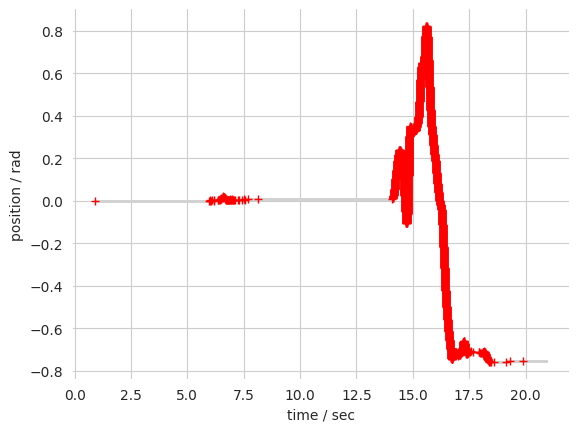

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times

sns.set_style('whitegrid')

pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
sec = 20 # Number of seconds to plot
plt.figure()

# Plot the interpolated data points
mask = t < (t[0] + sec)
plt.plot(t[mask], pos[mask], '.', markeredgecolor='lightgrey', markersize=1)

# Plot the original data
mask = wheel.timestamps < (wheel.timestamps[0] + sec)
plt.plot(wheel.timestamps[mask], wheel.position[mask], 'r+', markersize=6)

# Labels etc.
plt.xlabel('time / sec')
plt.ylabel('position / rad')
plt.box(on=None)
plt.show()

In [ ]:
# Convert the pos threshold defaults from samples to correct unit
thresholds_cm = wh.samples_to_cm(np.array([8, 1.5]), resolution=wh.ENC_RES)
thresholds = wh.cm_to_rad(thresholds_cm)

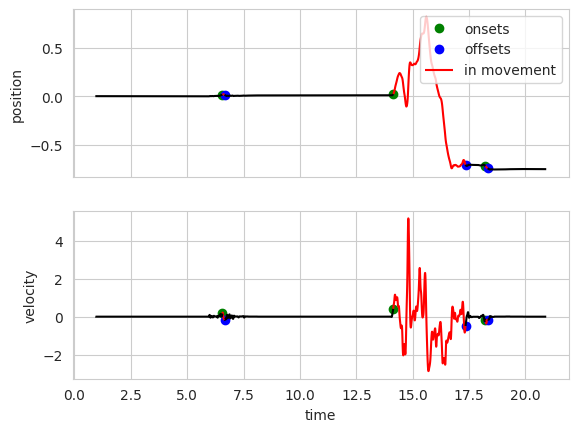

In [ ]:
# Detect wheel movements for the first 5 seconds
mask = t < (t[0] + sec)

onsets, offsets, peak_amp, peak_vel_times = wh.movements(
    t[mask], pos[mask], pos_thresh=thresholds[0], pos_thresh_onset=thresholds[0], make_plots=True)
plt.show()

In [ ]:
threshold_deg = 35 # visual degrees
gain = 4  # deg / mm
threshold_rad = wh.cm_to_rad(1e-1) * (threshold_deg / gain)  # rad

print('The wheel must be turned ~%.1f rad to move the stimulus to threshold' % threshold_rad)

The wheel must be turned ~0.3 rad to move the stimulus to threshold


In [ ]:
# pos was the output of interpolate_position using the default frequency of 1000Hz
Fs = 1000
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position, freq=Fs)
vel, acc = wh.velocity_filtered(pos, Fs)

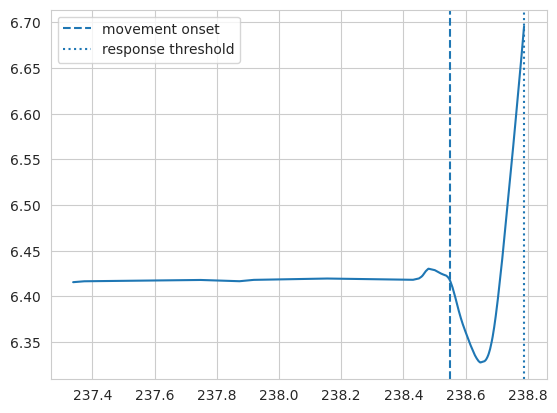

In [ ]:
trial_data = one.load_object(eid, 'trials', collection='alf')
ts = wh.get_movement_onset(wheel_moves.intervals, trial_data.response_times)

# The time from final movement onset to response threshold
movement_response_times = trial_data.response_times - ts

idx = 15 # trial index
mask = np.logical_and(trial_data['goCue_times'][idx] < t, t < trial_data['feedback_times'][idx])
plt.figure();
plt.plot(t[mask], pos[mask]);
plt.axvline(x=ts[idx], label='movement onset', linestyle='--');
plt.axvline(x=trial_data.response_times[idx], label='response threshold', linestyle=':');
plt.legend()
plt.show()

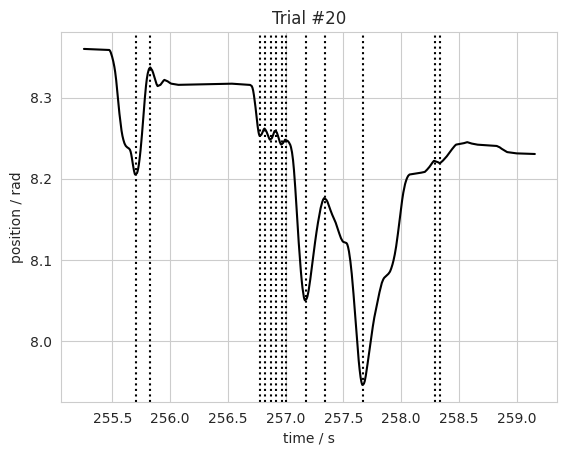

In [ ]:
n = 20  # trial number
start, end = trial_data['intervals'][n,]  # trial intervals
intervals = wheel_moves['intervals']  # movement onsets and offsets

# Find direction changes for a given trial
mask = np.logical_and(intervals[:,0] > start, intervals[:,0] < end)
change_times, idx, = wh.direction_changes(t, vel, intervals[mask])

plt.figure()
mask = np.logical_and(t > start, t < end)  # trial intervals mask
plt.plot(t[mask], pos[mask], 'k')  # plot wheel trace for trial
for i in np.concatenate(change_times):
    plt.axvline(x=i, color='k', linestyle=':')

plt.title('Trial #%s' % n)
plt.xlabel('time / s')
plt.ylabel('position / rad');
plt.show()

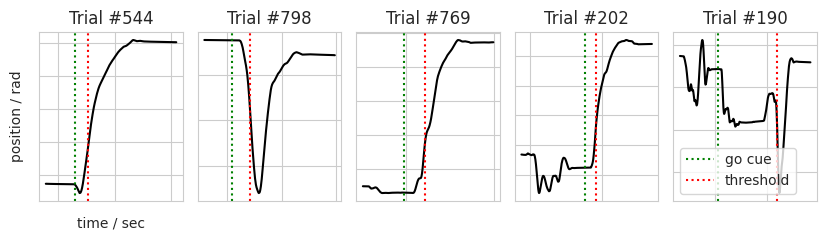

In [ ]:
n_trials = 5  # Number of trials to plot
# Randomly select the trials to plot
trial_ids = np.random.randint(trial_data['choice'].size, size=n_trials)
fig, axs = plt.subplots(1, n_trials, figsize=(8.5,2.5))
plt.tight_layout()

# Plot go cue and response times
goCues = trial_data['goCue_times'][trial_ids]
responses = trial_data['response_times'][trial_ids]

# Plot traces between trial intervals
starts = trial_data['intervals'][trial_ids, 0]
ends = trial_data['intervals'][trial_ids, 1]
# Cut up the wheel vectors
traces = wh.traces_by_trial(t, pos, start=starts, end=ends)
zipped = zip(traces, axs, goCues, responses, trial_ids)

for (trace, ax, go, resp, n) in zipped:
    ax.plot(trace[0], trace[1], 'k-')
    ax.axvline(x=go, color='g', label='go cue', linestyle=':')
    ax.axvline(x=resp, color='r', label='threshold', linestyle=':')
    ax.set_title('Trial #%s' % n)

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Add labels to first
axs[0].set_xlabel('time / sec')
axs[0].set_ylabel('position / rad')
plt.legend();
plt.tight_layout()
plt.show()

In [ ]:
goCues = trial_data['goCue_times']
responses = trial_data['response_times']

intervals = np.column_stack((goCues,responses))
print(intervals)

[[ 164.63150187  166.0896055 ]
 [ 168.9091074   169.88399547]
 [ 174.18831276  175.09199784]
 ...
 [4021.86663978 4022.15585042]
 [4024.93689939 4025.24375889]
 [4027.96652973 4063.05563563]]


In [ ]:
from brainbox.population.decode import get_spike_counts_in_bins

spike_count, cluster_id = get_spike_counts_in_bins(filtered_spikes['times'], filtered_spikes['clusters'], intervals)

num_neuron = len(np.unique(filtered_spikes['clusters']))
num_trial = len(intervals)

spike_rate = spike_count / (intervals[:,1] - intervals[:,0])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

assert len(np.unique(sl.trials.choice)) == 2

X = spike_count.T
y = sl.trials.choice

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=47)

print(f'Training set : {len(np.where(y_train == 1)[0])} choice +1 / {len(y_train)} trials')
print(f'Testing set : {len(np.where(y_test == 1)[0])} choice +1 / {len(y_test)} trials')

Training set : 187 choice +1 / 450 trials
Testing set : 193 choice +1 / 450 trials


In [ ]:
clf = LogisticRegression(C=0.2,penalty='l1',solver='liblinear',
                         max_iter=100,random_state=47).fit(X_train, y_train)

choice_predicted = clf.predict(X_test)
n_trial_correct = len(np.where(y_test == choice_predicted)[0])
print(f'Accuracy : {n_trial_correct} trials correctly predicted / {len(y_test)} trials')
print(f'Accuracy : {n_trial_correct/len(y_test)} percent')

Accuracy : 395 trials correctly predicted / 450 trials
Accuracy : 0.8777777777777778 percent


In [ ]:
results = pd.DataFrame(clf.coef_)

display(results)

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,0.126255,0.0,0.150078,0.0,0.080508,0.0,-0.047794,0.0,0.182788,0.0,...,0.026584,0.104602,-0.000829,0.0,0.0,0.0,0.0,-0.066644,0.418779,0.0


In [ ]:
inds = np.argwhere(clf.coef_ == 0)
mdl = cluster_id[inds[2,]]
print(mdl)

[24 41]
